In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2022-09-20 15:46:40.142821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 15:46:40.142889: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# directory structure
main_directory/

...class_a/

......a_image_1.jpg

......a_image_2.jpg

...class_b/

......b_image_1.jpg

......b_image_2.jpg

In [3]:
# generates a tf.data.Dataset from image files in a directory
dataset = tf.keras.utils.image_dataset_from_directory(
    "data",    # directory name 
    seed = 42,
    shuffle = True,   # whether to shuffle the data 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),    # (height, width) pixel value
    batch_size = BATCH_SIZE    
)

Found 2152 files belonging to 3 classes.


2022-09-20 15:46:55.388742: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-09-20 15:46:55.388799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fx-H410M-H-V3): /proc/driver/nvidia/version does not exist
2022-09-20 15:46:55.409226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
class_names = dataset.class_names      # folder names is class names 
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)  #68x32 = 2176 , total_image = 2152, create batches from this all image file of size 32,last batch size is not perfect
# total get 68 batches 

68

In [6]:
for image_batch, label_batch in dataset.take(1):          # take first batch
    print(image_batch.shape)   # (total_images, height, width, channel)
    print(label_batch.numpy())  # tensor to numpy, 0,1,2 -> 3 class

(32, 256, 256, 3)
[1 2 1 1 2 0 0 1 1 1 1 0 0 1 1 0 0 2 0 0 1 0 0 0 1 0 0 1 0 2 2 0]


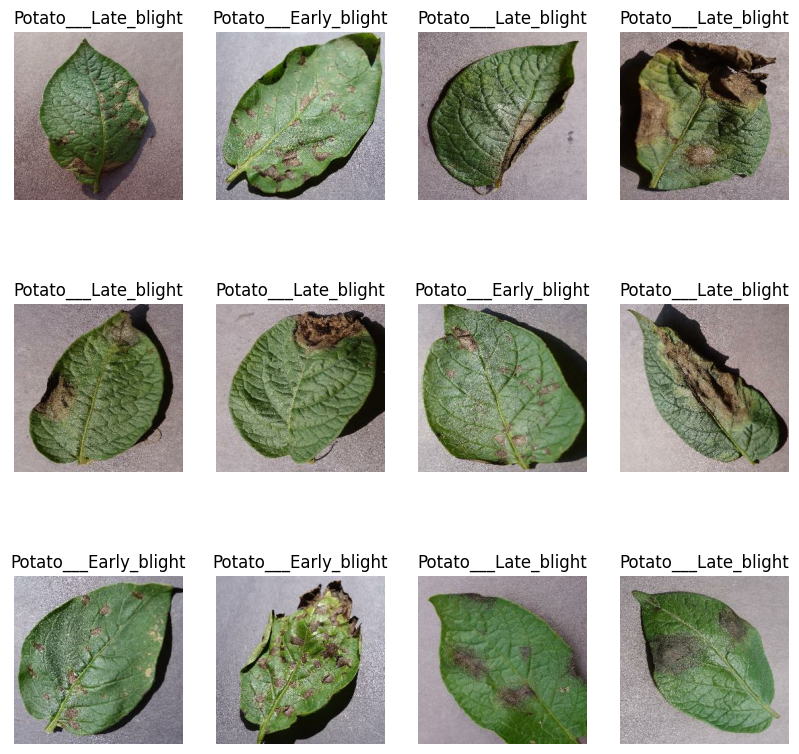

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(1,13):
        ax = plt.subplot(3,4,i)  #(nrows, ncolumns, index)
        plt.imshow(image_batch[i].numpy().astype('uint8'))  # data range(2^8 - 1 = 255), pixel value range 0-255
        plt.title(class_names[label_batch[i]])
        plt.axis("off")   # print image without axis value

In [8]:
# train, test and validation split
def get_dataset_partitions_tf(ds, train_split = 0.8,test_split =0.1, validation_split= 0.1,shuffle = True, shuffle_size = 10000):
    assert (train_split+test_split+validation_split) == 1            # if this condition is going to fail it generates the AssertionError

    ds_size = len(ds)
    if shuffle:
        # shuffle method take sequence and reorganize the order of the items
        ds = ds.shuffle(shuffle_size, seed = 42)


    train_size = int(train_split*ds_size)
    train_ds = ds.take(train_size)

    val_size = int(validation_split*ds_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)            # 68*08 = 54.04

54

In [11]:
len(val_ds)

6

In [12]:
len(test_ds)

8

Cache, Shuffle and Prefetch the Dataset

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.Rescaling(1./255.)    # normalization 
])

In [15]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
# applying data augmentation to training data set 
train_ds = train_ds.map(
    lambda x,y : (data_augmentation(x, training = True), y)
).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

In [18]:
model.build(input_shape= input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 86s 2s/step - loss: 0.8516 - accuracy: 0.5340 - val_loss: 0.5963 - val_accuracy: 0.7396
Epoch 2/50
54/54 [==============================] - 81s 1s/step - loss: 0.4969 - accuracy: 0.7840 - val_loss: 0.3371 - val_accuracy: 0.8646
Epoch 3/50
54/54 [==============================] - 75s 1s/step - loss: 0.3771 - accuracy: 0.8415 - val_loss: 0.3744 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 75s 1s/step - loss: 0.2926 - accuracy: 0.8826 - val_loss: 0.2135 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 75s 1s/step - loss: 0.1943 - accuracy: 0.9284 - val_loss: 0.1411 - val_accuracy: 0.9635
Epoch 6/50
54/54 [==============================] - 75s 1s/step - loss: 0.2295 - accuracy: 0.9114 - val_loss: 0.1495 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 76s 1s/step - loss: 0.1791 - accuracy: 0.9302 - val_loss: 0.1393 - val_accuracy: 0.9479
Epoch 8/50
54/54 [==

In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 234ms/step - loss: 0.0921 - accuracy: 0.9727


In [23]:
scores

[0.09211236983537674, 0.97265625]

In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

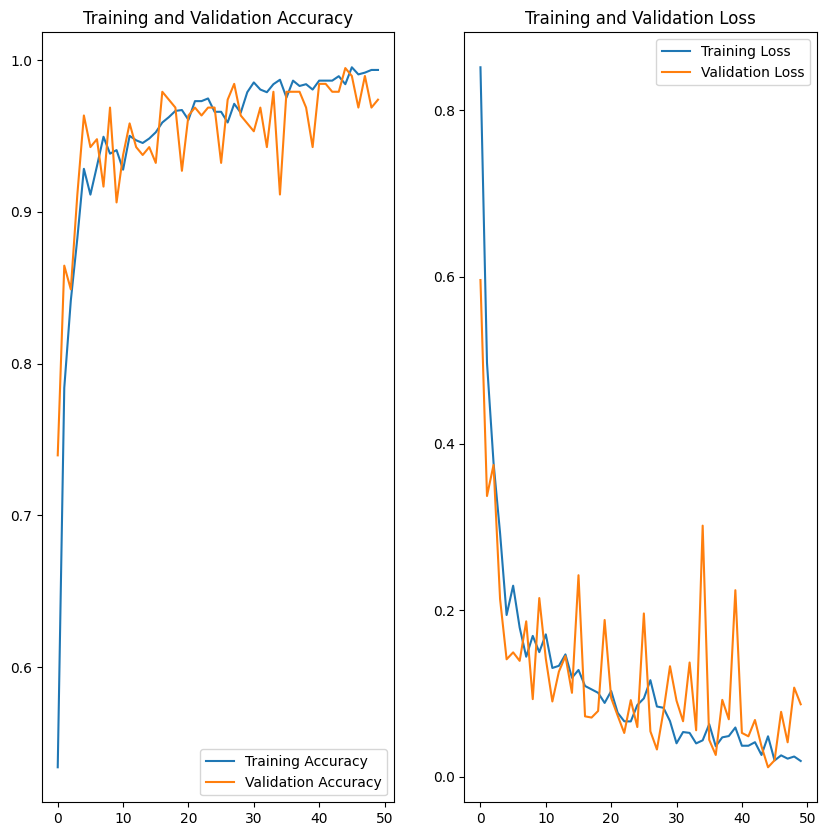

In [32]:
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label : Potato___Early_blight
1/1 [==============================] - 0s 233ms/step
predicted label : Potato___Early_blight


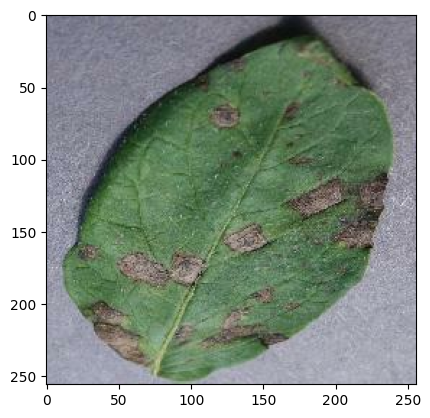

In [52]:
# run prediction on a sample image 
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print('actual label :' ,class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print('predicted label :' ,class_names[np.argmax(batch_prediction[0])])

In [56]:
# write a function for interface 
def predict(model, images):
    img_array = tf.keras.preprocessing.image.img_to_array(images.numpy())     # Converts a PIL Image instance to a Numpy array.
    img_array = tf.expand_dims(img_array, 0) # 0 -> row, 1 -> columns   / create a batch    

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions)]
    confidence = round(100 * (np.max(predictions)), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


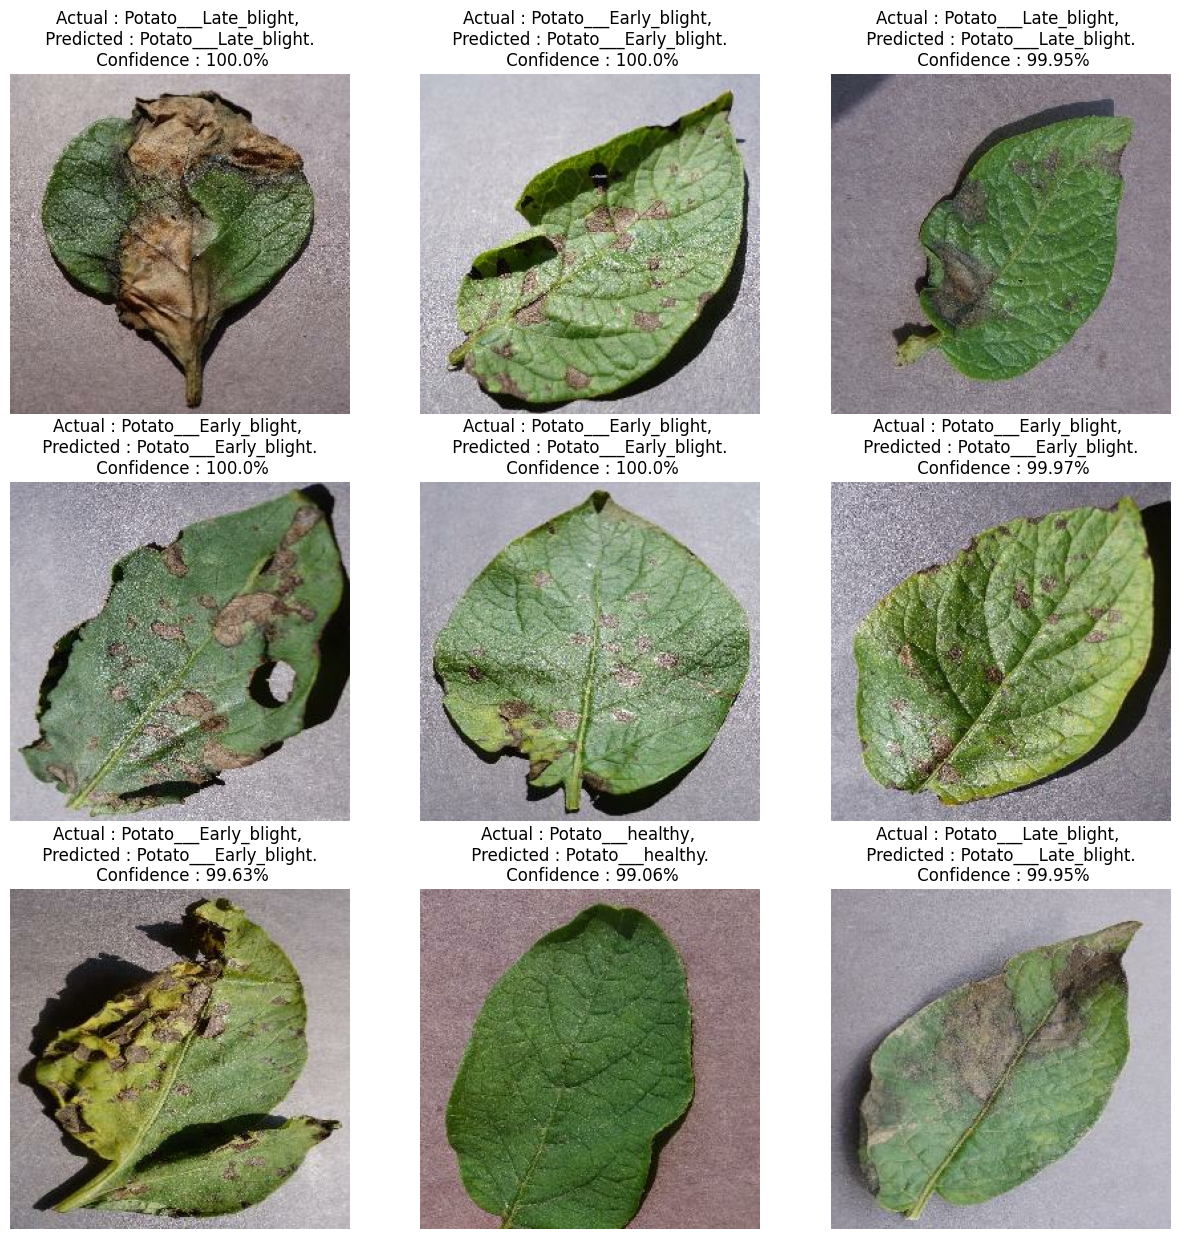

In [57]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual : {actual_class}, \n Predicted : {predicted_class}. \n Confidence : {confidence}%")

        plt.axis("off")        

In [62]:
model.save("models/potatoes.h5")